In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
import textwrap
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter
from nltk.tokenize import word_tokenize
from transformers import pipeline
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /Users/apare/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Step 1: Load Dataset
data = pd.read_csv('kaggle_data_mental_health.csv')

In [3]:
# Step 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:\n")
print(data.info())
print("\nFirst 5 Rows:\n")
print(data.head())
print("\nMissing Values:\n")
print(data.isnull().sum())

data['Context_Length'] = data['Context'].fillna('').apply(lambda x: len(x.split()))
data['Response_Length'] = data['Response'].fillna('').apply(lambda x: len(x.split()))

print("\nContext Length Statistics:\n")
print(data['Context_Length'].describe())
print("\nResponse Length Statistics:\n")
print(data['Response_Length'].describe())

Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB
None

First 5 Rows:

                                             Context  \
0  I'm going through some things with my feelings...   
1  I'm going through some things with my feelings...   
2  I'm going through some things with my feelings...   
3  I'm going through some things with my feelings...   
4  I'm going through some things with my feelings...   

                                            Response  
0  If everyone thinks you're worthless, then mayb...  
1  Hello, and thank you for your question and see...  
2  First thing I'd suggest is getting the sleep y...  
3  Therapy is essential for those that are feelin...  
4  I first want to let you know that you are not 

In [4]:
# Step 3: Finding Unique Words in 'Context' and 'Response'
# Fill NaN values with empty strings
data['Context'] = data['Context'].fillna('')
data['Response'] = data['Response'].fillna('')

unique_words_context = set(' '.join(data['Context']).split())
unique_words_response = set(' '.join(data['Response']).split())

print(f"\nNumber of Unique Words in Context: {len(unique_words_context)}")
print(f"Number of Unique Words in Response: {len(unique_words_response)}")





Number of Unique Words in Context: 5776
Number of Unique Words in Response: 26016


In [5]:
data.head()

,Context,Response,Context_Length,Response_Length
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",60,163
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",60,367
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,60,60
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,60,137
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,60,63


In [6]:
# Function to split texts into unique sentences
def get_unique_sentences_from_column(column):
    sentences = set()  # Use a set to ensure uniqueness
    for text in column:
        for sentence in text.split('.'):  # Split by '.'
            clean_sentence = sentence.strip()
            if clean_sentence:  # Ignore empty sentences
                sentences.add(clean_sentence)
    return list(sentences)

# Get unique sentences from 'Context' column
unique_sentences = get_unique_sentences_from_column(data['Context'])



In [7]:
len(unique_sentences)

4047

In [8]:

contexts = data['Context']


emotion_model = pipeline('sentiment-analysis', model='j-hartmann/emotion-english-distilroberta-base')



def analyze_emotions(text, model, max_length=512):
    chunks = textwrap.wrap(text, max_length)  # Split text into chunks
    emotions = []
    for chunk in chunks:
        result = model(chunk)
        emotions.append(result[0]['label'])  # Extract top emotion label
    return max(set(emotions), key=emotions.count)  # Return the most frequent emotion


results = []
for sentence in tqdm(data['Context'], total=len(data['Context'])):
    emotion = analyze_emotions(sentence, emotion_model)
    results.append(emotion)


data['Sentiment'] = results


Device set to use mps:0


  0%|          | 0/3512 [00:00<?, ?it/s]

In [18]:
data['Sentiment'].value_counts()

Sentiment
sadness     1053
fear         955
neutral      506
anger        464
disgust      276
surprise     174
joy           84
Name: count, dtype: int64

#### Vectorization

In [ ]:

vectorizer = TfidfVectorizer()
with mlflow.start_run():
    tfidf_matrix = vectorizer.fit_transform(contexts)
    tfidf_array = tfidf_matrix.toarray()

    mlflow.sklearn.log_model(vectorizer, "vectorizer")
    mlflow.log_param("vectorizer_type", "vectorizer")
    mlflow.log_metric("number_of_features", tfidf_array.shape[1])



2024/12/18 21:56:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024/12/18 21:56:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [20]:
tfidf_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Model Creation

In [21]:

X_train, X_test, y_train, y_test = train_test_split(tfidf_array, data['Sentiment'], test_size=0.3, random_state=42)

In [22]:

model = RandomForestClassifier()

In [14]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'max_depth': None, 'n_estimators': 300}


In [15]:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the 

In [16]:
model = RandomForestClassifier(n_estimators=300, max_depth=None)
    
with mlflow.start_run():
    mlflow.log_param("n_estimators", 300)
    mlflow.log_param("max_depth", None)
    model.fit(X_train, y_train)
    mlflow.sklearn.log_model(model, "random_forest_model")
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    mlflow.log_metric("train_accuracy", train_score)
    mlflow.log_metric("test_accuracy", test_score)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Accuracy: 0.9345351043643264
Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.85      0.90       137
     disgust       1.00      0.83      0.91        90
        fear       0.97      0.95      0.96       285
         joy       1.00      0.81      0.90        27
     neutral       0.97      0.93      0.95       136
     sadness       0.87      0.99      0.93       338
    surprise       0.93      0.95      0.94        41

    accuracy                           0.93      1054
   macro avg       0.96      0.90      0.93      1054
weighted avg       0.94      0.93      0.93      1054

Confusion Matrix:
[[116   0   3   0   3  15   0]
 [  4  75   2   0   0   9   0]
 [  0   0 272   0   0  12   1]
 [  0   0   2  22   1   2   0]
 [  1   0   0   0 127   8   0]
 [  0   0   2   0   0 334   2]
 [  0   0   0   0   0   2  39]]


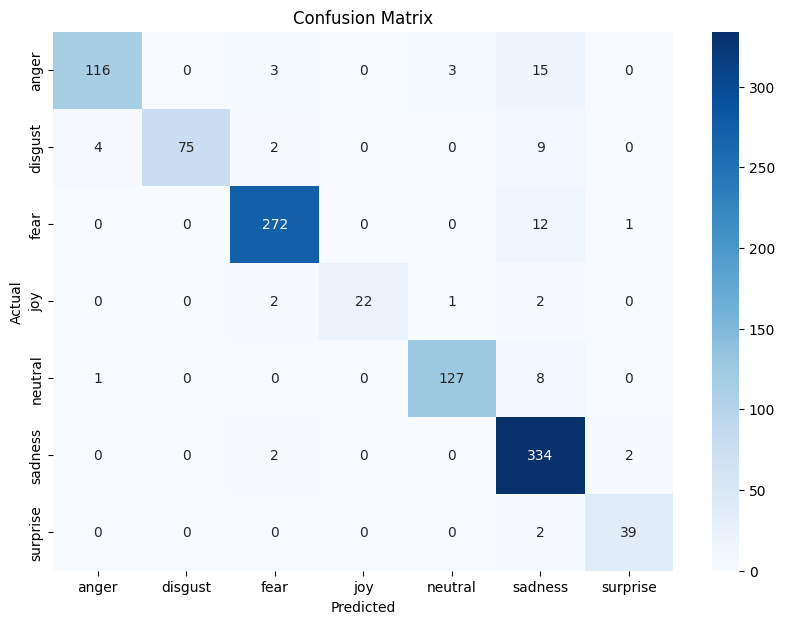

In [17]:

y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


print("Classification Report:")
print(classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()